# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install statsmodels

In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [4]:
energy_df = pd.read_csv('../data/energy.csv')
energy_df.head(10)

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
5,2012-01-01 05:00:00,"2,453.00",31.33
6,2012-01-01 06:00:00,"2,560.00",30.00
7,2012-01-01 07:00:00,"2,719.00",29.00
8,2012-01-01 08:00:00,"2,916.00",29.00
9,2012-01-01 09:00:00,"3,105.00",33.33


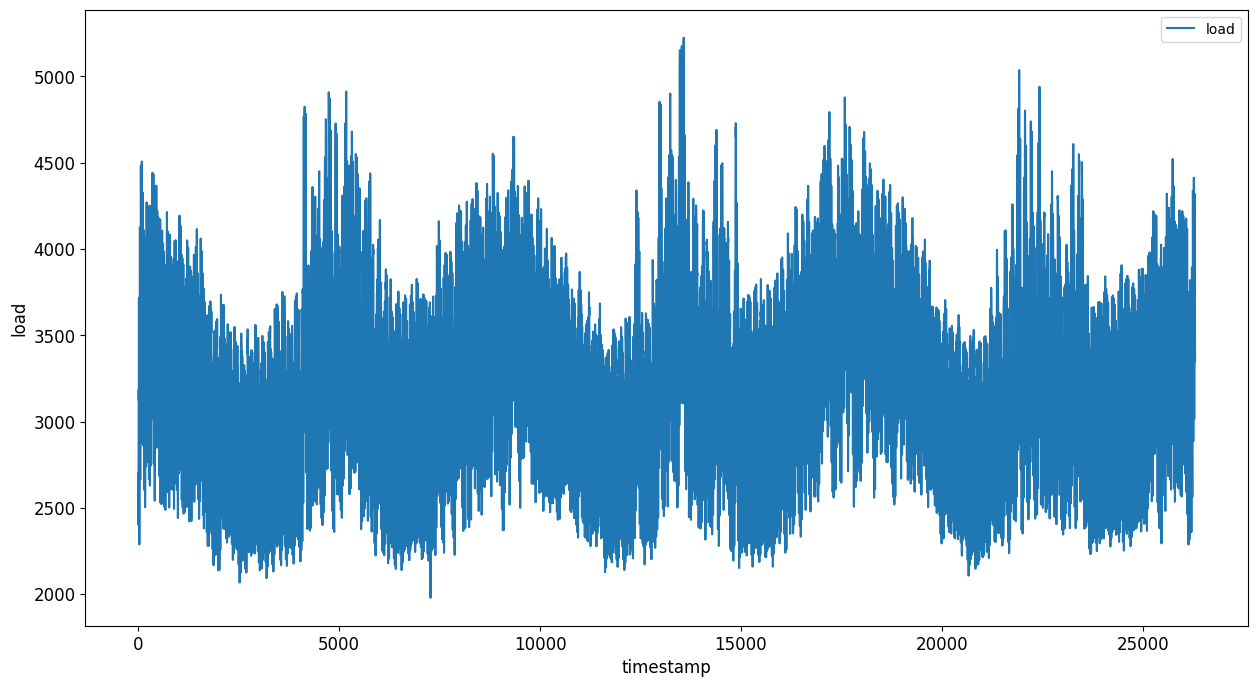

In [5]:
energy_df.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [6]:
energy_df=energy_df.set_index('timestamp')
energy_df

,load,temp
timestamp,,
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00


In [7]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

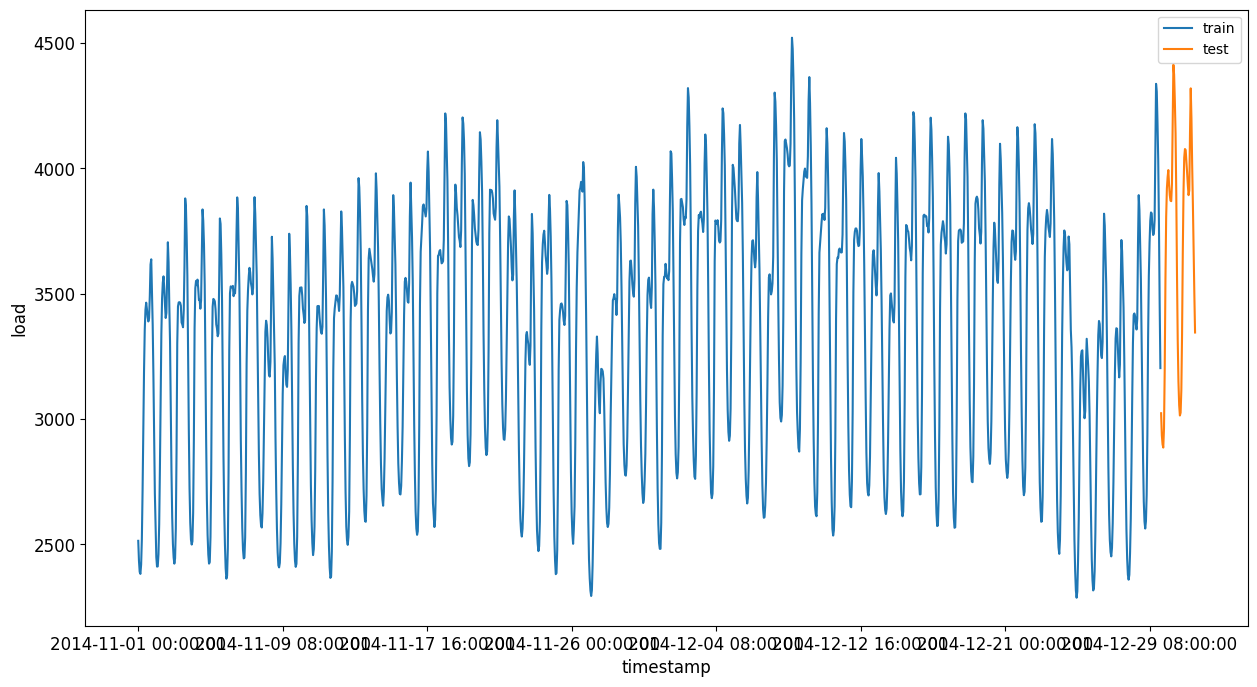

In [8]:
energy_df[(energy_df.index < test_start_dt) & (energy_df.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy_df[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [9]:
train = energy_df.copy()[(energy_df.index >= train_start_dt) & (energy_df.index < test_start_dt)][['load']]
test = energy_df.copy()[energy_df.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [10]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40


<Axes: ylabel='Frequency'>

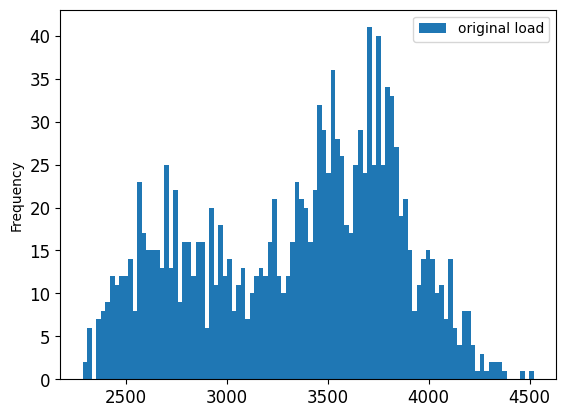

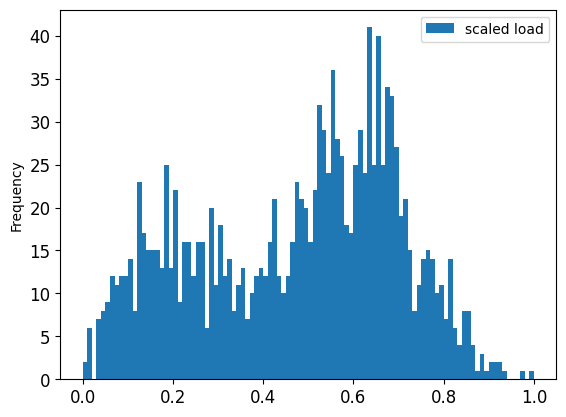

In [11]:
energy_df[(energy_df.index >= train_start_dt) & (energy_df.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)

In [12]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [13]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [14]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.237
Date:                            Fri, 07 Jul 2023   AIC                          -6942.474
Time:                                    13:12:11   BIC                          -6911.047
Sample:                                11-01-2014   HQIC                         -6930.722
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8388      0.016     52.180      0.000       0.807       0.870
ar.L2         -0.5203      0.034   

In [15]:
test_shifted = test.copy()
test_shifted.index = pd.to_datetime(test_shifted.index)

for t in range(1, HORIZON+1):
  test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
timestamp,,,,
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


In [21]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.73097582811101

In [36]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[1:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')

# Ensure that the length of test_ts matches the length of the index
test_ts = test_ts[:len(eval_df)]

eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()[45:]
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 01:00:00,t+1,"3,008.79","2,935.00"
1,2014-12-30 02:00:00,t+1,"2,955.55","2,899.00"
2,2014-12-30 03:00:00,t+1,"2,900.21","2,886.00"
3,2014-12-30 04:00:00,t+1,"2,917.59","2,963.00"
4,2014-12-30 05:00:00,t+1,"2,946.37","3,199.00"


In [37]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.03
t+2   0.04
t+3   0.04
Name: APE, dtype: float64


In [38]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  3.4948273445587446 %


In [39]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  3.7371583308260243 %


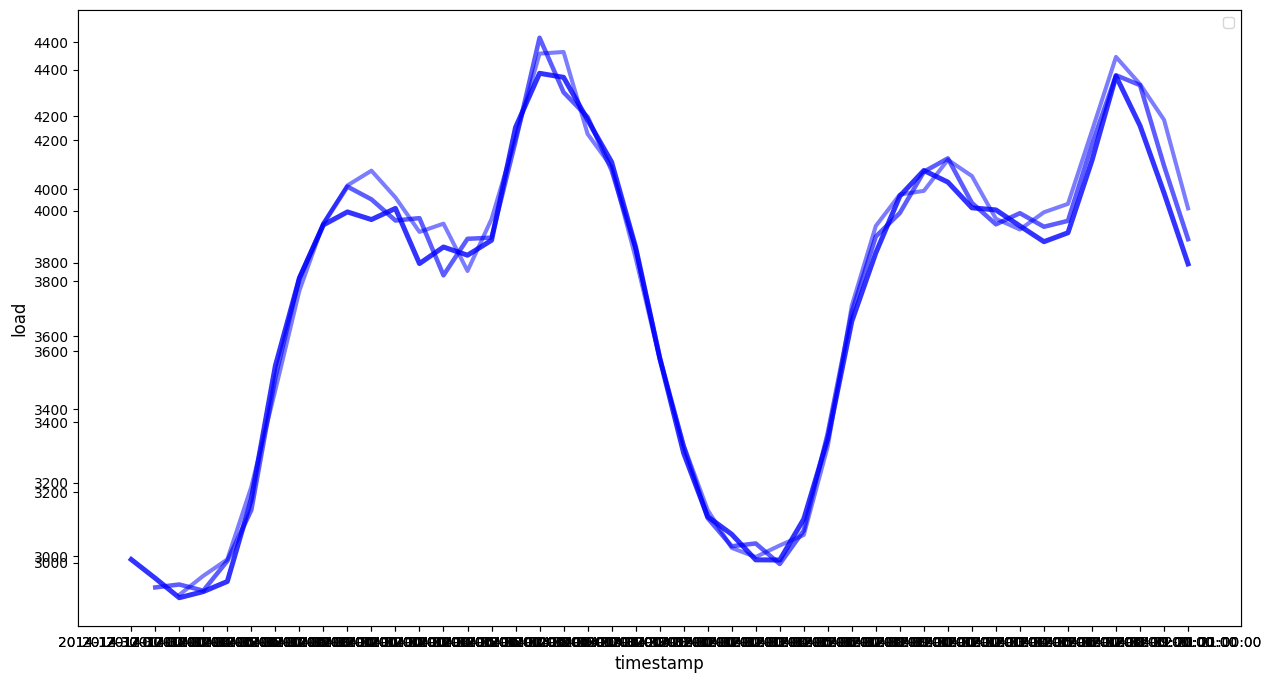

In [40]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [41]:
train_ts = train['load']
test_ts = test_shifted

print(range(test_ts.shape[0]))

range(0, 45)
